# CUDA Lab Assignment 5

## **Group members**

1. Areesha Asif
2. Abhishek S Pillai 

## Dataset Overview:
CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities and large quantities including: 

10,177 number of identities,

202,599 number of face images

In [1]:
import torchvision 
from glob import glob
from torchvision.models import resnet18
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import lpips
import optuna
import optuna.visualization.matplotlib as oplt
from tqdm import tqdm
from torch import Tensor
from torch.utils.data import DataLoader
from torchsummary import summary

In [2]:

# Transformation to convert images to tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)), # Resize the images to a common size
    transforms.ToTensor()
])

# Load the datasets
train_dataset = datasets.ImageFolder(root='./img_align_celeba/train', transform=transform)
validation_dataset = datasets.ImageFolder(root='./img_align_celeba/valid', transform=transform)
test_dataset = datasets.ImageFolder(root='./img_align_celeba/test', transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=False)

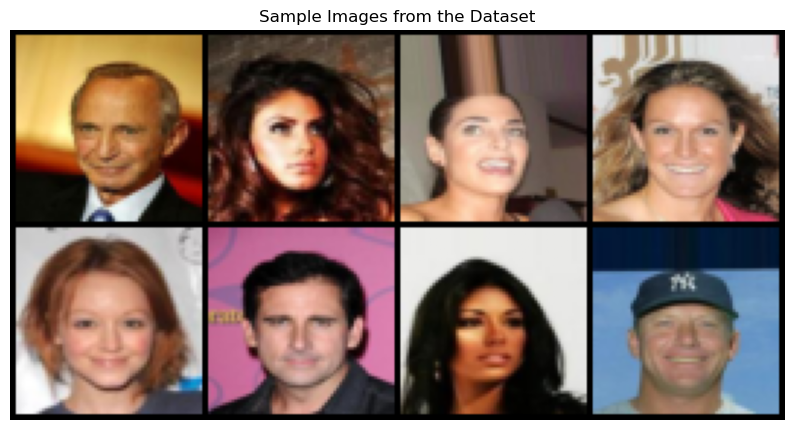

In [3]:

# Function to show images with improved aesthetics
def imshow(img, title=None):   
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))  # Set the figure size
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Remove the axis
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8], nrow=4), title="Sample Images from the Dataset")

In [4]:
batch_size = 32  # number of inputs in each batch
epochs = 10  # times to run the model on complete data
lr = 1e-3  # learning rate
train_loss = []
image_size = 32  # dimension of the image
hidden_size = 1024  # hidden dimension
latent_size = 32  # latent vector dimension

In [5]:
# Fetch one batch of images
images, labels = next(iter(train_loader))

# Look at the shape of the first image
print(images[0].shape)


torch.Size([3, 64, 64])


# ConVAE

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), 1024, 1, 1)


class VAE(nn.Module):
    def __init__(
        self,
        image_channels=3,
        image_dim=32,
        hidden_size=hidden_size,
        latent_size=latent_size,
    ):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, 4, 2),
            nn.ReLU(0.2),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(0.2),
            nn.Conv2d(64, 128, 4, 2),
            nn.ReLU(0.2),
            nn.Conv2d(128, 256, 4, 2),
            nn.ReLU(0.2),
            Flatten(),
        )
        self.encoder_mean = nn.Linear(hidden_size, latent_size)
        self.encoder_logvar = nn.Linear(hidden_size, latent_size)
        self.fc = nn.Linear(latent_size, hidden_size)
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(hidden_size, 128, 5, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 6, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, 6, 2),
            nn.Sigmoid(),
        )
        self.z = None

    def sample(self, log_var, mean):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def forward(self, x):
        x = self.encoder(x)
        log_var = self.encoder_logvar(x)
        mean = self.encoder_mean(x)
        z = self.sample(log_var, mean)
        x = self.fc(z)
        self.z = z
        x = self.decoder(x)
        return x, mean, log_var

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.style.use('seaborn')
print(device)

cuda


In [8]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-5):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [9]:
@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None):
    loss_list = []
    recons_loss = []
    kld_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        reconstructed_image, mean, log_var = model(images)
                 
        CE = F.binary_cross_entropy(reconstructed_image, images, reduction="sum")
        KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        loss = CE + KLD
        loss_list.append(loss.item())
        recons_loss.append(CE.item())
        kld_loss.append(KLD.item())
        
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    recons_loss = np.mean(recons_loss)
    kld_loss = np.mean(kld_loss)
    return loss, recons_loss, kld_loss

In [10]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, mu, log_var = model(images)
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list

In [11]:
def train_model(model, optimizer, scheduler, criterion, train_loader,
                valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    val_loss_recons =  []
    val_loss_kld =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % 5 == 0 or epoch == num_epochs - 1)
        loss, recons_loss, kld_loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch
            )
        val_loss.append(loss)
        val_loss_recons.append(recons_loss)
        val_loss_kld.append(kld_loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"       Valid loss recons: {round(val_loss_recons[-1], 5)}")
            print(f"       Valid loss KL-D:   {round(val_loss_kld[-1], 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld

In [12]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4)

In [13]:
vae

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU(inplace=True)
    (8): Flatten()
  )
  (encoder_mean): Linear(in_features=1024, out_features=32, bias=True)
  (encoder_logvar): Linear(in_features=1024, out_features=32, bias=True)
  (fc): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )


In [14]:
# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=vae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10
    )

Epoch 1 Iter 2533: loss 0.01261. : 100%|████████████████████████████████████████████| 2533/2533 [02:16<00:00, 18.49it/s]


    Train loss: 0.01951
    Valid loss: 136494.23444
       Valid loss recons: 136494.06626
       Valid loss KL-D:   0.1655


Epoch 6 Iter 2533: loss 0.01174. : 100%|████████████████████████████████████████████| 2533/2533 [02:13<00:00, 19.04it/s]


    Train loss: 0.01229
    Valid loss: 102102.11681
       Valid loss recons: 100656.86595
       Valid loss KL-D:   1445.25075


Epoch 10 Iter 2533: loss 0.01215. : 100%|███████████████████████████████████████████| 2533/2533 [02:12<00:00, 19.10it/s]

    Train loss: 0.01195
    Valid loss: 101943.45444
       Valid loss recons: 100540.74155
       Valid loss KL-D:   1402.71298
Training completed


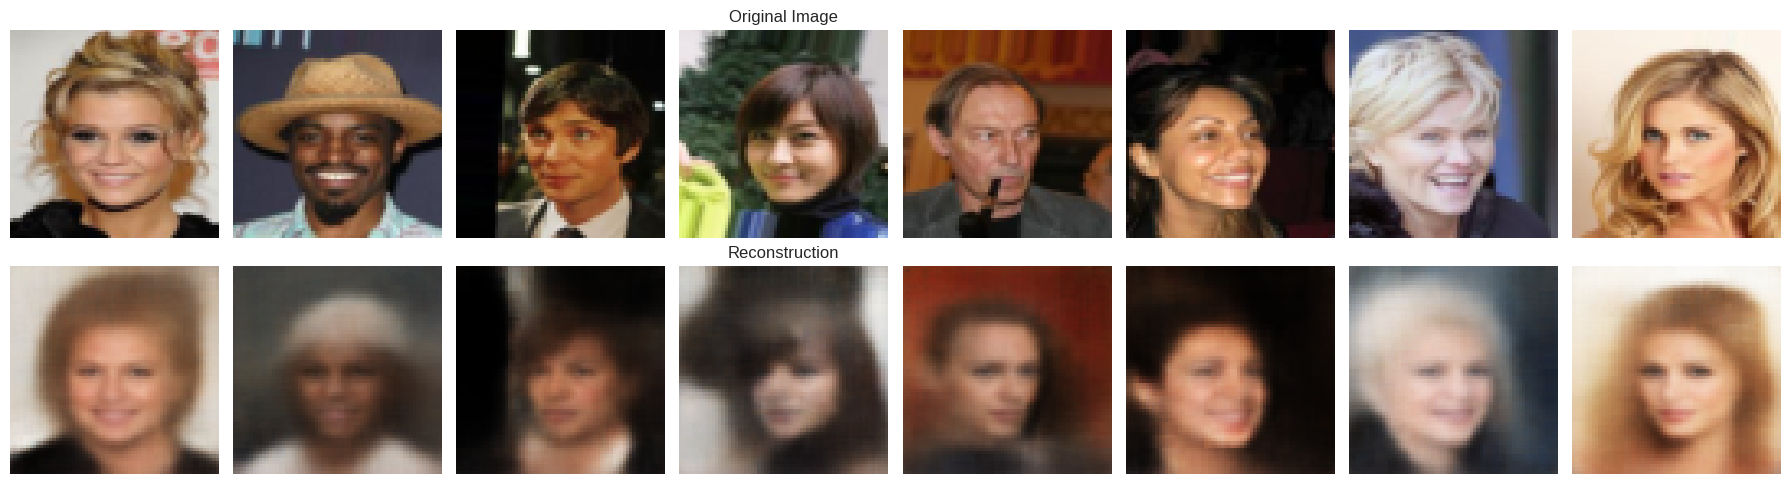

In [15]:
imgs, _ = next(iter(test_loader))

vae.eval()
with torch.no_grad():
    # Adjusting to unpack all four outputs from the VAE model
    recons, _, _ = vae(imgs.to(device))

fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[0, i].imshow(imgs[i].permute(1,2,0).cpu().numpy())
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i].permute(1,2,0).cpu().numpy())
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()


Observations and comments about the reconstructed images:

Fidelity: The reconstructed images retain a general likeness to the originals, capturing major features such as the face outline, eyes, and hair. This suggests that the VAE has learned a meaningful representation of the data.

Blurriness: The reconstructed images are noticeably blurrier than the originals due to the model's tendency to generate averages of possible inputs. The blurriness also indicates that the VAE may be capturing the general features but losing some of the finer details.

Feature Preservation: Key facial features such as eyes, nose, and mouth seem to be preserved to some extent, although they are less sharp.

Loss of Detail:This loss could be due to the bottleneck in the VAE architecture, where the model compresses the data into a lower-dimensional latent space.

Consistency: The consistency in the level of detail and quality across all reconstructed images suggests that the VAE is applying a consistent encoding and decoding process

General Function to plot results of models

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def smooth(loss_list, smoothing_window):
    cumsum_vec = np.cumsum(np.insert(loss_list, 0, 0)) 
    smooth = (cumsum_vec[smoothing_window:] - cumsum_vec[:-smoothing_window]) / smoothing_window
    return smooth

def plot_losses(train_loss, val_loss, loss_iters, val_loss_recons, model_name):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(24, 5)

    # Smoothed losses
    smooth_loss = smooth(loss_iters, 31)

    # Length adjustment for smoothed loss
    smooth_len = len(smooth_loss)
    loss_len = len(loss_iters)
    START = 500  

    # Ensuing that we do not exceed the length of loss_iters
    plot_len = min(smooth_len, loss_len - START)

    # Plot 1: Loss vs Iterations
    ax[0].plot(loss_iters[:plot_len], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss[:plot_len], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Loss")
    ax[0].set_yscale("log")
    ax[0].set_title(f"{model_name} Training Progress")

    # Plot 2: Adjusted for smoothing
    ax[1].plot(np.arange(START, START + plot_len), loss_iters[START:START + plot_len], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(np.arange(START, START + plot_len), smooth_loss[:plot_len], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Loss")
    ax[1].set_yscale("log")
    ax[1].set_title(f"{model_name} Training Progress from Iter {START}")

    # Plot 3: Training and Validation Loss
    epochs = np.arange(len(train_loss)) + 1
    ax[2].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
    ax[2].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("Loss")
    ax[2].set_title(f"{model_name} Loss Curves")
    # Plot 4: Independant loss curves
    epochs = np.arange(len(val_loss)) + 1
    ax[3].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss Total", linewidth=3) 
    ax[3].plot(epochs[1:], val_loss_recons[1:], c="green", label="Recons. Loss", linewidth=2)
    ax[3].plot(epochs[1:], val_loss_kld[1:], c="purple", label="KLD Loss", linewidth=2)
    ax[3].legend(loc="best")
    ax[3].set_xlabel("Epochs")
    ax[3].set_ylabel("Loss")
    ax[3].set_yscale("log")
    ax[3].set_title("Independent Loss Curves")


    plt.show()
    

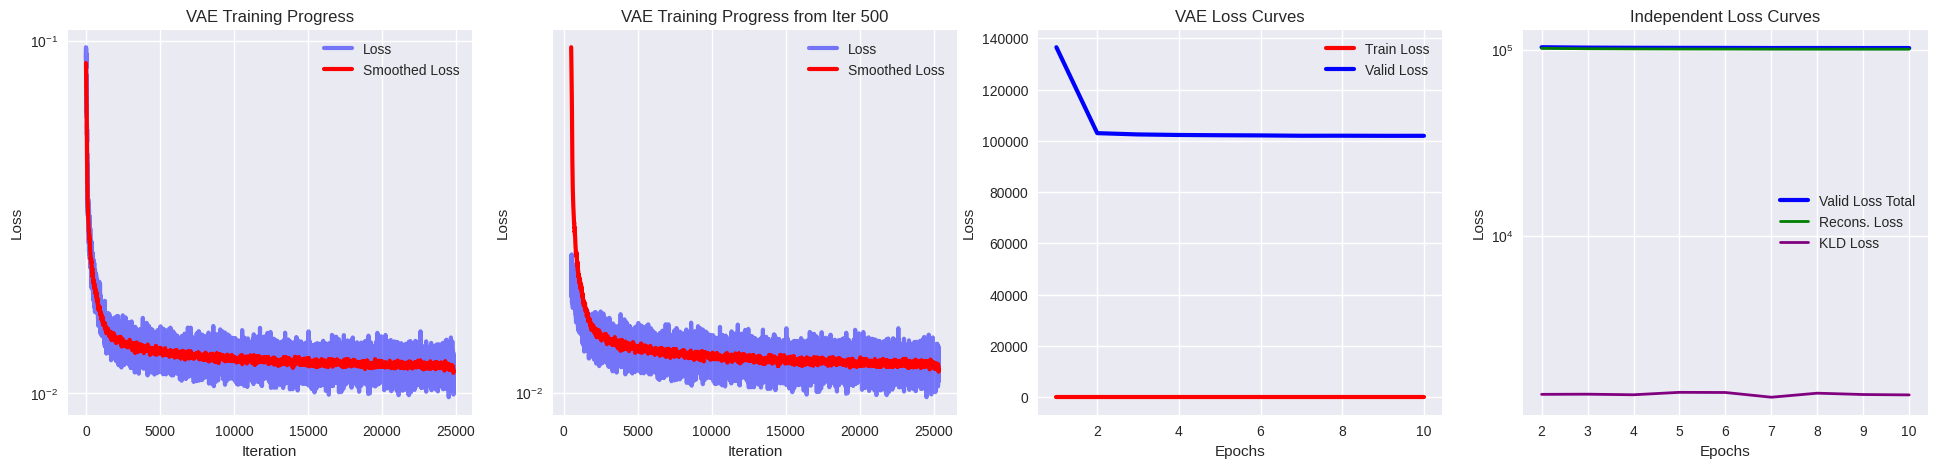

In [20]:
train_loss_vae = train_loss.copy()
val_loss_vae = val_loss.copy()
loss_iters_vae = loss_iters.copy()
val_loss_recons_vae = val_loss_recons.copy()
plot_losses(train_loss_vae, val_loss_vae, loss_iters_vae, val_loss_recons_vae, "VAE")

VAE Training Progress (First Two Plots):

These two plots depict the loss over the number of iterations with both the raw loss (blue) and the smoothed loss (red). The initial sharp decrease in loss suggests that the model is rapidly learning from the data at the beginning of training.As training proceeds, the loss continues to decline but at a more gradual rate, as seen by the red line representing the smoothed loss, which indicates the general trend of the model's learning.
The log scale on the y-axis allows us to see the reduction in loss even when it becomes relatively small, highlighting the improvements in the model's performance over time.

VAE Loss Curves (Third Plot):

This plot shows the training and validation loss over epochs, which provides a view of the loss trends over the entire training dataset. The consistent decrease in both curves, without signs of divergence, suggests that the model is not overfitting and is improving its performance on unseen data as well.

Independent Loss Curves (Fourth Plot):

This plot likely represents the breakdown of the total loss into its two main components: the reconstruction loss and the KL divergence, which are standard components of the VAE loss function.
The reconstruction loss is usually the dominant component, as it reflects the model's ability to recreate the input data. The relatively stable and low KL divergence suggests that the model's learned latent distribution matches the prior distribution well and is consistent across epochs.


Interpretation of the Results:

Learning Dynamics: The model shows healthy learning dynamics, as indicated by the steady decline in the training and validation losses. The smoothness of the curves, particularly in the third plot, suggests that the learning process is stable.

Generalization: The close tracking of the validation loss with the training loss indicates that the model is generalizing well to new data.

Loss Components: The independent loss curves suggest that the model's latent space is being regularized effectively, as evidenced by the low KL divergence. The relatively high reconstruction loss compared to KL divergence is typical in VAEs and may point to an emphasis on learning the data distribution rather than overly constraining the latent space.

Optimization: The plots do not show signs of common training issues such as overfitting or mode collapse, which is when a model could potentially ignore the latent space and collapse to a state where it generates very similar outputs regardless of the input.

# Implement a ConvVAE using a pretrained encoder (e.g. ResNet18)
modifying the ResNet18 model to use it as an encoder for the VAE

In [21]:
from torchvision.models import resnet18
class ResNetEncoder(nn.Module):
    def __init__(self, latent_size):
        super(ResNetEncoder, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, latent_size * 2)

    def forward(self, x):
        latent = self.resnet(x)
        mean = latent[:, :latent_size]
        log_var = latent[:, latent_size:]
        return mean, log_var


Following is the mirrored version of the ResNet18 as a decoder

In [22]:
class ResNetDecoder(nn.Module):
    def __init__(self, latent_size):
        super(ResNetDecoder, self).__init__()

        # Define initial size for the first ConvTranspose2d layer
        self.init_size = 256  # Adjust this size as needed
        self.fc = nn.Linear(latent_size, self.init_size * 4 * 4)  # Adjust to match the spatial dimensions

        # Upscaling layers
        self.upconv3 = nn.ConvTranspose2d(self.init_size, 128, kernel_size=4, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)

        # Final layer to map to 3 channels (64x64)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.init_size, 4, 4)  # Reshape to a feature map

        x = F.relu(self.upconv3(x))
        x = F.relu(self.upconv2(x))
        x = F.relu(self.upconv1(x))
        x = self.final_layer(x)

        return x


Now the complete ConvVAE model using the ResNet-based encoder and decoder

In [23]:
class ResNetVAE(nn.Module):
    def __init__(self, latent_size):
        super(ResNetVAE, self).__init__()
        self.encoder = ResNetEncoder(latent_size)
        self.decoder = ResNetDecoder(latent_size)  # Pass latent_size here

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z), mean, logvar


Printing model architecture 

In [24]:
# Instantiate a ResNet18 model
resnet18_model = resnet18(pretrained=True)

# Print the architecture
print(resnet18_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/user/spillaia0/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/spillaia0/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instantiating the model, optimizer, and starting training

In [25]:
latent_size = 32  
resnet_vae = ResNetVAE(latent_size=latent_size).to(device)

# Using the same optimizer as before
optimizer = torch.optim.Adam(resnet_vae.parameters(), lr=3e-4)

# The training function remains the same
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=resnet_vae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10
    )


Epoch 1 Iter 2533: loss 0.01460. : 100%|████████████████████████████████████████████| 2533/2533 [02:27<00:00, 17.19it/s]


    Train loss: 0.02011
    Valid loss: 137645.9209
       Valid loss recons: 137045.43146
       Valid loss KL-D:   600.48948


Epoch 5 Iter 2533: loss 0.01144. : 100%|████████████████████████████████████████████| 2533/2533 [02:27<00:00, 17.19it/s]


Epoch 00015: reducing learning rate of group 0 to 3.0000e-05.


Epoch 6 Iter 2533: loss 0.01328. : 100%|████████████████████████████████████████████| 2533/2533 [02:26<00:00, 17.27it/s]


    Train loss: 0.01264
    Valid loss: 102192.53005
       Valid loss recons: 100770.01468
       Valid loss KL-D:   1422.51537


Epoch 10 Iter 2533: loss 0.01559. : 100%|███████████████████████████████████████████| 2533/2533 [02:26<00:00, 17.29it/s]

    Train loss: 0.01204
    Valid loss: 101783.09266
       Valid loss recons: 100365.68846
       Valid loss KL-D:   1417.4042
Training completed


Visualizing outputs from resnet18 VAE model

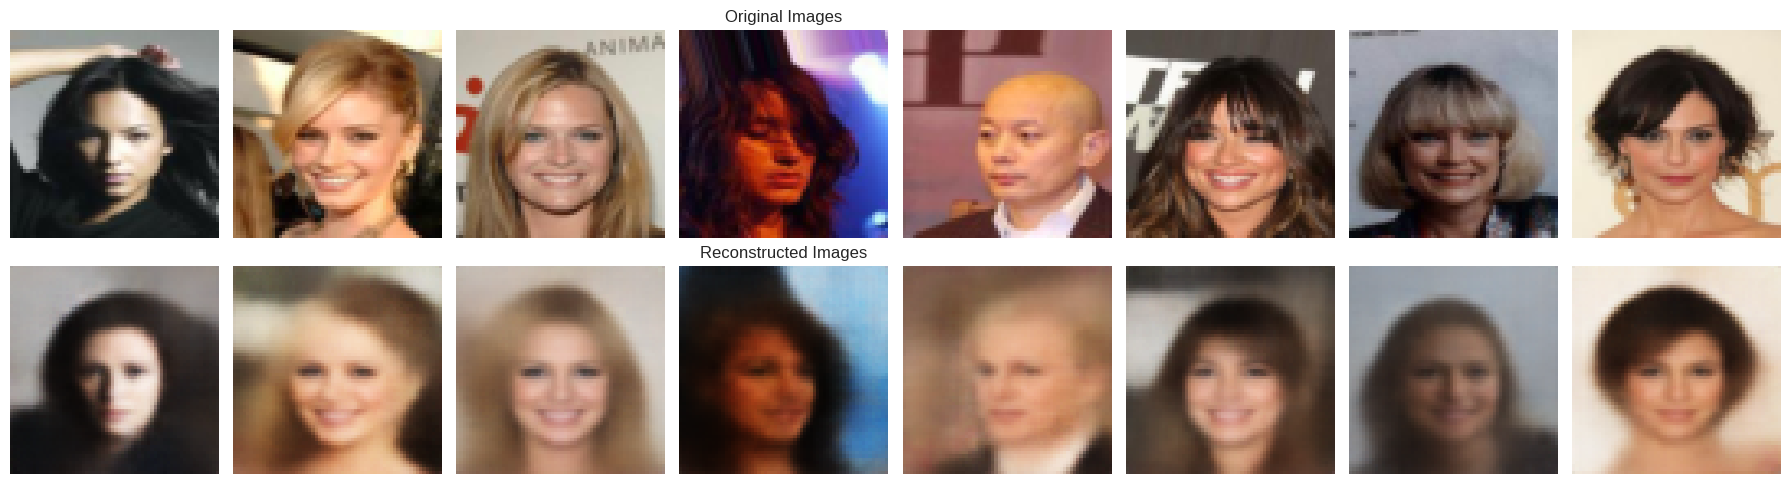

In [26]:
# Fetch a batch of images from the test loader
imgs, _ = next(iter(test_loader))

# Set the model to evaluation mode
resnet_vae.eval()

with torch.no_grad():
    # Pass the images through the model
    recons, _, _ = resnet_vae(imgs.to(device))

# Prepare the plot
fig, ax = plt.subplots(2, 8, figsize=(18, 5))

# Display original and reconstructed images
for i in range(8):
    # Original images
    ax[0, i].imshow(imgs[i].permute(1, 2, 0).cpu().numpy())
    ax[0, i].axis('off')

    # Reconstructed images
    reconstructed = recons[i].permute(1, 2, 0).cpu().numpy()
    ax[1, i].imshow(reconstructed)
    ax[1, i].axis('off')

# Add titles
ax[0, 3].set_title('Original Images')
ax[1, 3].set_title('Reconstructed Images')

# Show the plot
plt.tight_layout()
plt.show()



ResNet-18 VAE Results:
In the image, where a ResNet-18 architecture is integrated into the VAE, the reconstructed images still exhibit some blurriness, but there is a noticeable improvement in detail retention compared to the standard VAE.

Detail and Sharpness: The ResNet-18 VAE seems to perform better in terms of capturing details compared to the standard VAE. This is likely due to the ResNet-18 architecture's capability to capture more complex patterns and features through its residual learning framework.

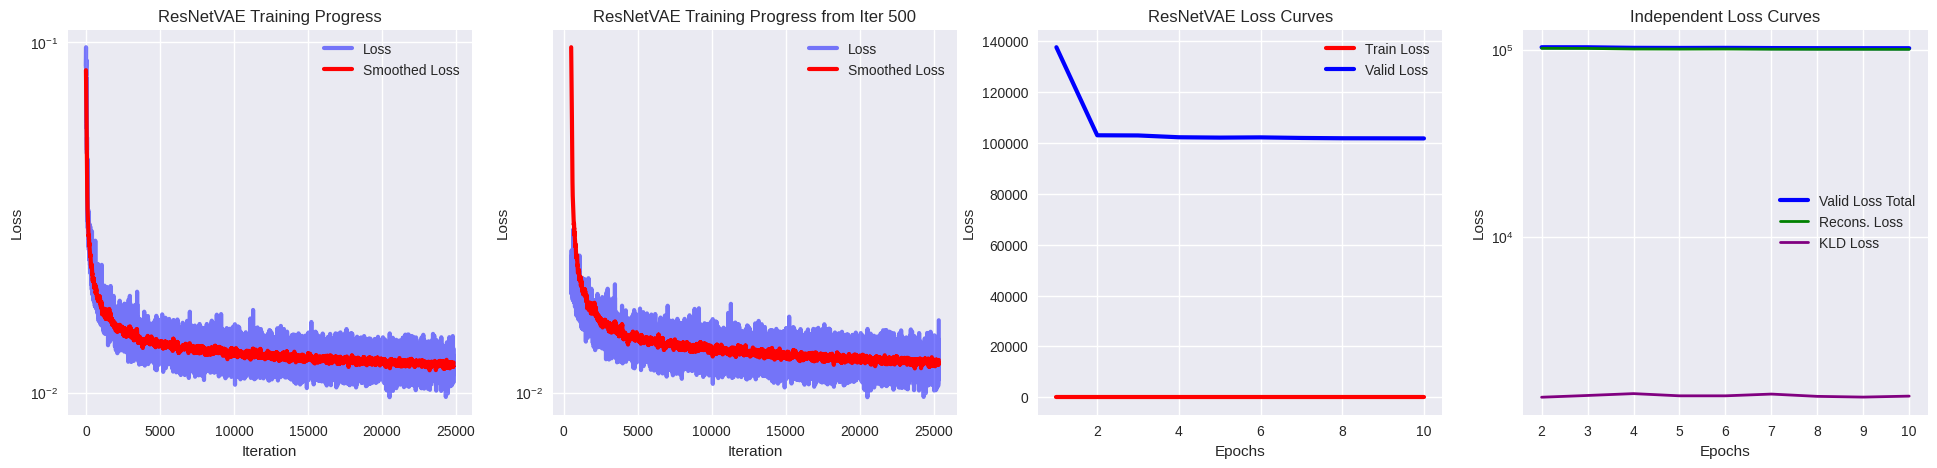

In [27]:
train_loss_resnet_vae = train_loss.copy()
val_loss_resnet_vae = val_loss.copy()
loss_iters_resnet_vae = loss_iters.copy()
val_loss_recons_resnet_vae = val_loss_recons.copy()
plot_losses(train_loss_resnet_vae, val_loss_resnet_vae, loss_iters_resnet_vae, val_loss_recons_resnet_vae, "ResNetVAE")

ResNet-VAE Training Progress (First Two Plots):

These plots show the training and validation losses over the number of iterations. Both the raw loss (blue) and the smoothed loss (red) are presented. The smoothing helps to visualize the overall trend by reducing the noise inherent in the training process.In the early phase of training, there's a sharp drop in both training and validation losses, which indicates rapid learning. After this initial phase, both losses continue to decrease but at a slower rate.
The validation loss follows the training loss closely, which suggests that the model is generalizing well and not overfitting to the training data.

ResNet-VAE Loss Curves (Third Plot):

This plot represents the loss over epochs. It shows a consistent decrease in both training and validation losses, aligning with the observations from the first two plots. The training loss is lower than the validation loss, which is typical behavior.The smooth transition without significant spikes or bumps suggests stable learning dynamics.

Independent Loss Curves (Fourth Plot):

This plot likely shows the decomposition of the total VAE loss into its two components: reconstruction loss and KL divergence loss. 
The reconstruction loss measures how well the VAE is reconstructing the input data, and the KL divergence quantifies how closely the learned latent distribution matches the prior distribution.
The reconstruction loss (presumably the blue line) remains relatively high compared to the KL loss (presumably the purple line), which is typical because the pixel-wise reconstruction loss usually contributes more to the total loss.
The KL divergence seems to be lower and flatter, which could indicate that the model has effectively learned a latent space that aligns with the prior distribution and remains stable across epochs.

# Investigate latent space and visualize some interpolations

In [38]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [39]:
imgs_flat, latents, labels = [], [], []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        img, mu, var = vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0], -1).numpy())  # Convert to numpy
        latents.append(vae.z.cpu().numpy())  # Convert to numpy
        labels.append(lbls.cpu().numpy())  # Convert to numpy

# Concatenate lists of arrays into single arrays
imgs_flat = np.concatenate(imgs_flat, axis=0)
latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0)

# Now check the unique labels
print("Unique labels after concatenation:", np.unique(labels))


Unique labels after concatenation: [0]


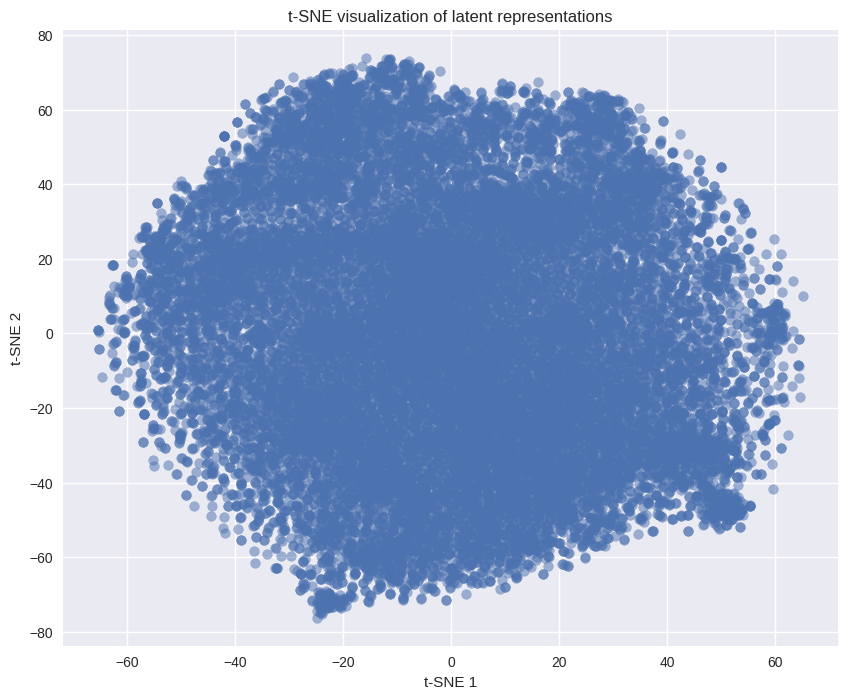

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming latents is your array of latent representations
tsne_latents = TSNE(n_components=2, random_state=42).fit_transform(latents)

# Plotting the result of t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(tsne_latents[:, 0], tsne_latents[:, 1], alpha=0.5)
plt.title('t-SNE visualization of latent representations')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()



t-Distributed Stochastic Neighbor Embedding (t-SNE) is a powerful tool for visualizing high-dimensional data. It can sometimes reveal more structure in the data than PCA, especially in the context of image data. In t-SNE plot, each point represents an encoded representation of an image in the latent space. The t-SNE algorithm has attempted to arrange these points in two dimensions such that similar points in the high-dimensional space are also close to each other in the 2D plot, while dissimilar points are further apart.

Clusters:in our plot, we see a sort of arc or crescent shape rather than distinct clusters, suggesting a continuous variation in the latent variables without discrete groupings.

Density:. In our plot, points are more concentrated in certain regions, which might suggest that many images have similar features or attributes that the VAE has encoded similarly.

Shapes and Patterns: The crescent shape seen in our plot might suggest a type of manifold structure in the latent space. Since the latent space is a learned representation, it could be capturing some underlying feature variation in a non-linear fashion, which is represented by the curvature in the t-SNE plot.

Outliers: If there were points far away from the main concentration of data, these could be considered outliers. They could represent unusual or rare images in your dataset. In our plot, there do not appear to be significant outliers, suggesting relatively uniform coverage of the latent space by your dataset.

In [46]:
COLORS = ['g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    # If legend is None, create a legend based on the unique labels
    legend = [f"Class {int(l)}" for l in np.unique(labels)] if legend is None else legend
    
    # If ax is None, create a new figure and axis
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12, 6))

    unique_labels = np.unique(labels)
    print("Unique labels found:", unique_labels)  # Debug: Print unique labels
    
    # Plot each class with a different color
    for i, l in enumerate(unique_labels):
        idx = np.where(labels == l)
        print(f"Plotting label {l} with color {COLORS[i % len(COLORS)]}")  # Debug: Print label and color
        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i % len(COLORS)])
    
    # Set legend location
    ax.legend(loc="best")


In [47]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_latents = PCA(n_components=2).fit_transform(latents)

Unique labels found: [0]
Plotting label 0 with color g
Unique labels found: [0]
Plotting label 0 with color g


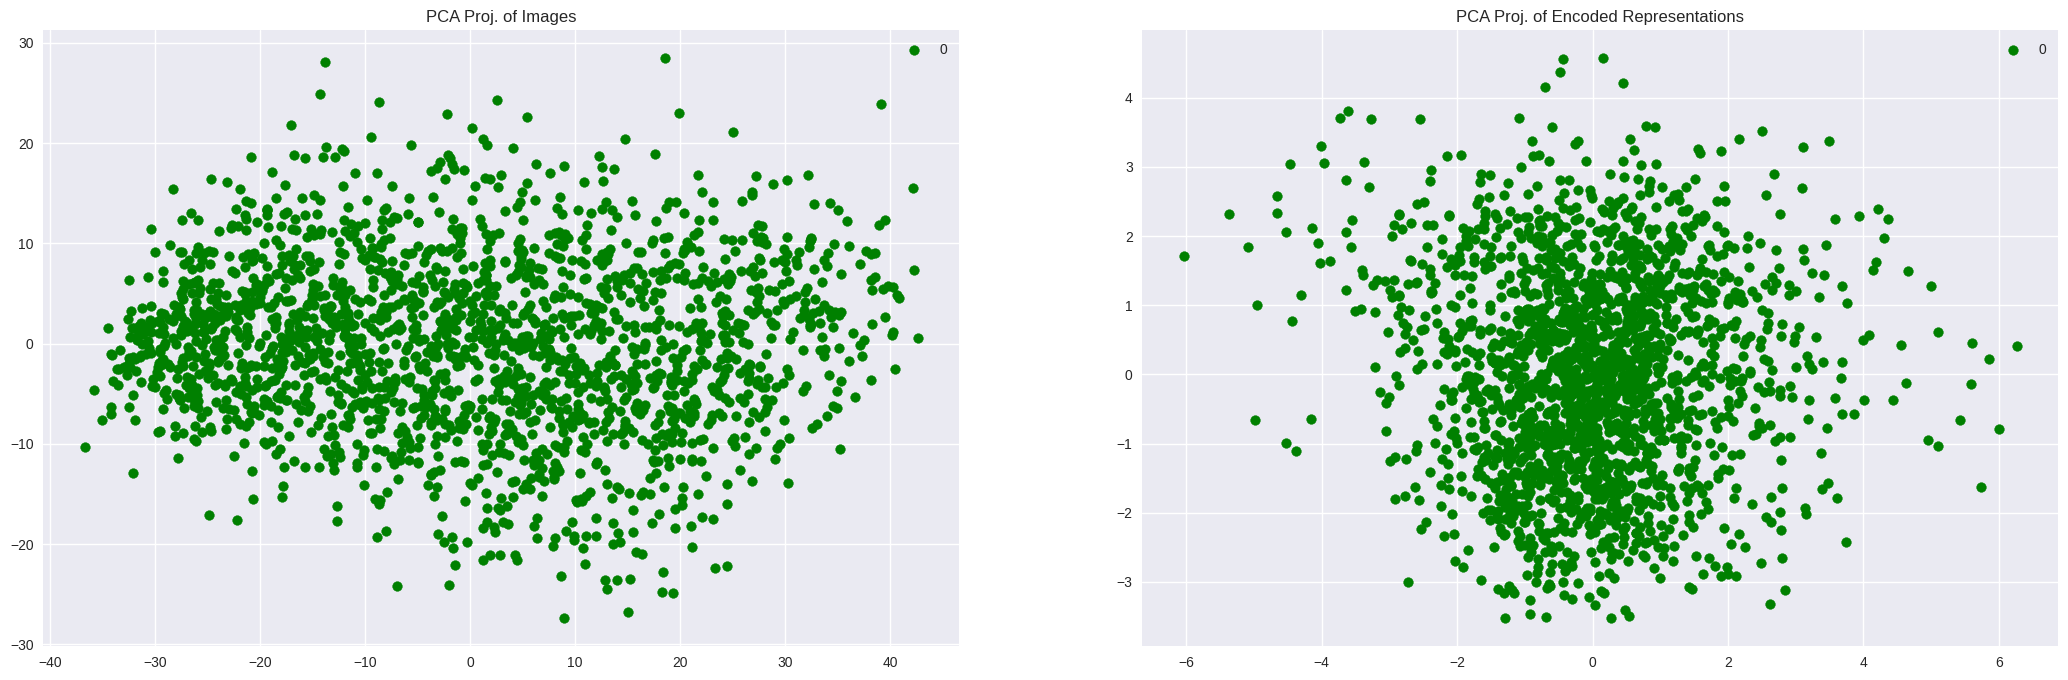

In [48]:
N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=[str(i) for i in range(0,10)])
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_latents[:N], labels[:N], ax=ax[1], legend=[str(i) for i in range(0,10)])
ax[1].set_title("PCA Proj. of Encoded Representations")
plt.show()

Our approach of using PCA for dimensionality reduction and visualizing the projections is a standard method for exploring and understanding the characteristics of high-dimensional data like the latent representations in a VAE. It's an effective way to qualitatively assess the performance of your model in terms of how well it separates or clusters different classes in the latent space.

Continuous Spectrum: The spread of the points indicates that there is a continuous spectrum of variation within the dataset, which the model has captured in its latent space. The lack of clustering suggests that the dataset does not have distinct, separable classes, or the model has not learned to separate them distinctly.

Latent Space Coverage: The density of points seems fairly uniform across the plot, which might suggest that the latent space does not have 'empty' regions; this indicate that the VAE has a good coverage of the data variance.

Only some Outliers: There do not seem to be significant outliers far from the main body of data points.This could imply that the VAE is encoding the images in a relatively consistent manner without any significant anomalies.

# Compare the models from a) and b)


# Qualitative Comparison

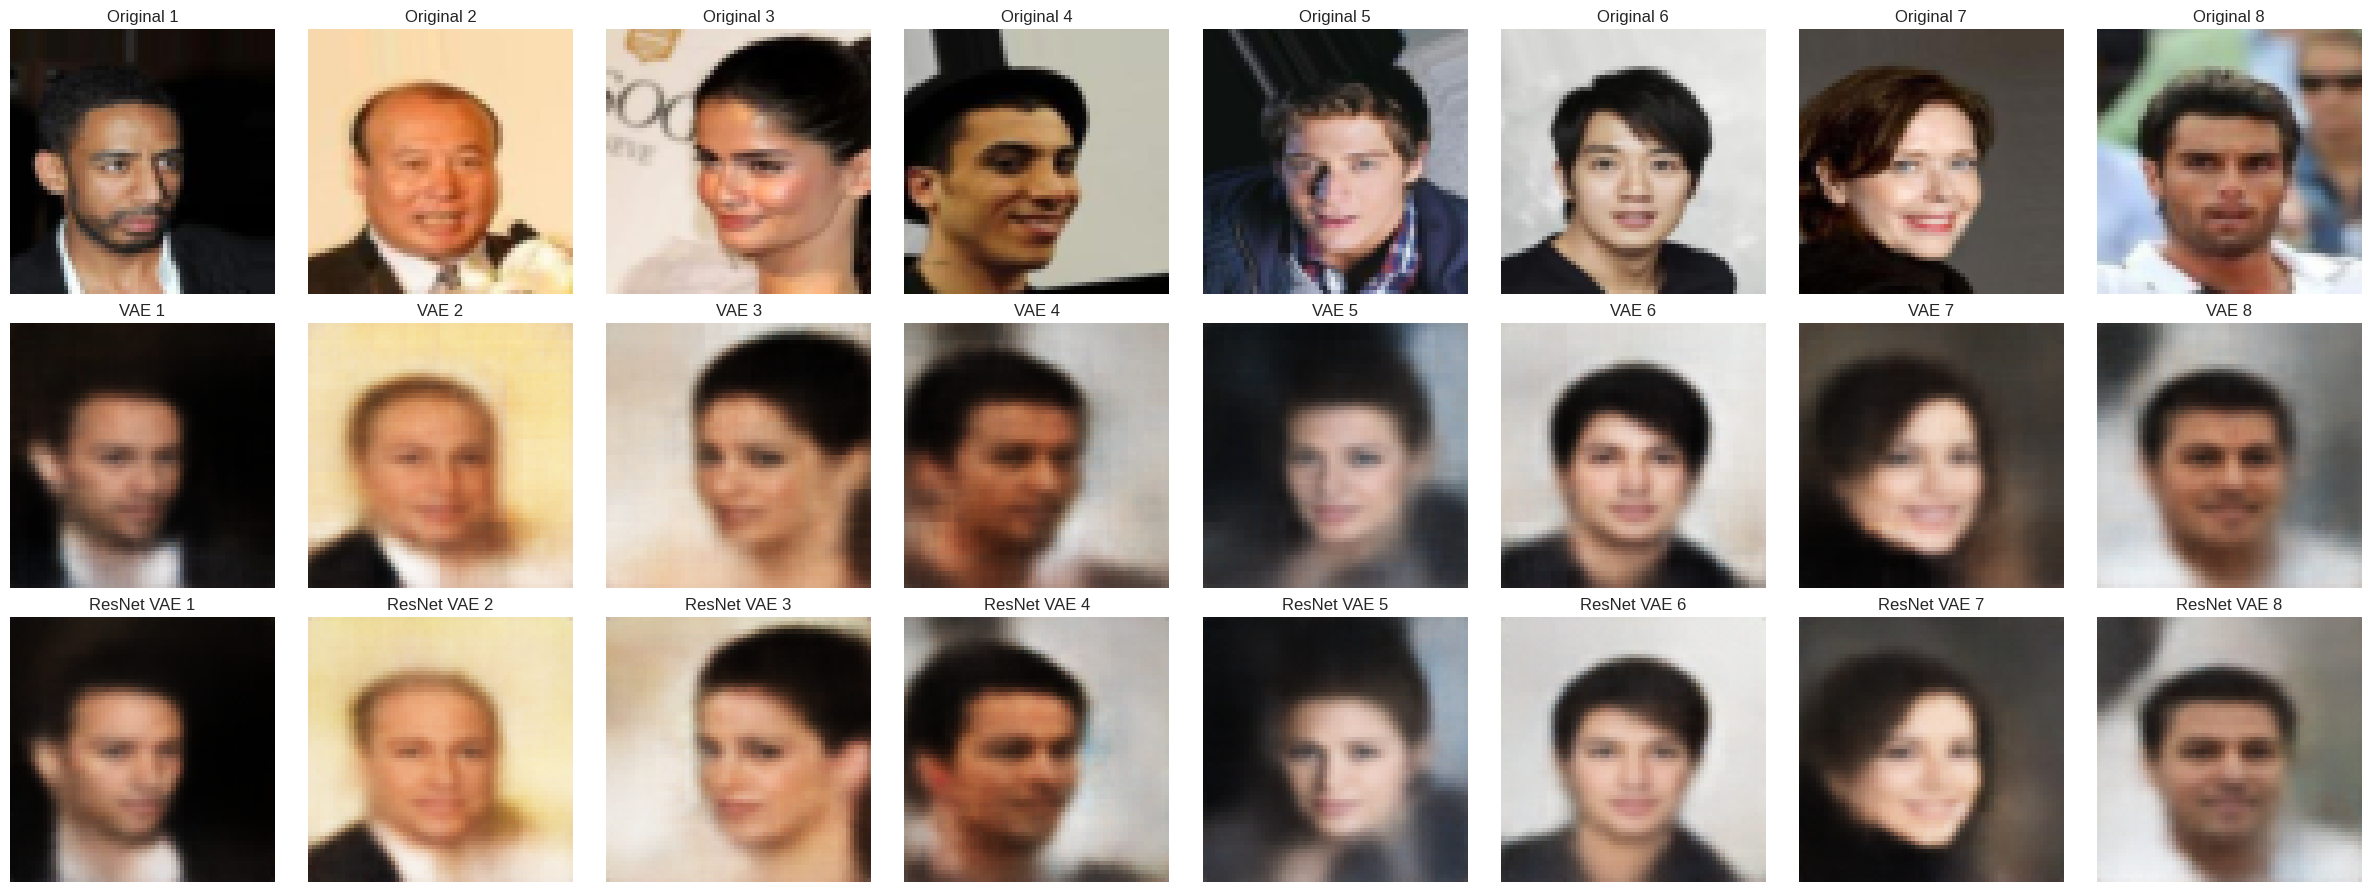

In [49]:
# Fetch a batch of images from the test loader
imgs, _ = next(iter(test_loader))

# Set the original VAE and ResNet VAE to evaluation mode
vae.eval()
resnet_vae.eval()

with torch.no_grad():
    # Pass the images through both models
    vae_recons, _, _ = vae(imgs.to(device))
    resnet_vae_recons, _, _ = resnet_vae(imgs.to(device))

# Prepare the plot for side-by-side comparison
fig, ax = plt.subplots(3, 8, figsize=(24, 9))

# Display original, VAE reconstructed, and ResNet VAE reconstructed images
for i in range(8):
    # Original images
    ax[0, i].imshow(imgs[i].permute(1, 2, 0).cpu().numpy())
    ax[0, i].axis('off')
    ax[0, i].set_title(f'Original {i+1}')

    # VAE reconstructed images
    vae_rec = vae_recons[i].permute(1, 2, 0).cpu().numpy()
    ax[1, i].imshow(vae_rec)
    ax[1, i].axis('off')
    ax[1, i].set_title(f'VAE {i+1}')

    # ResNet VAE reconstructed images
    resnet_rec = resnet_vae_recons[i].permute(1, 2, 0).cpu().numpy()
    ax[2, i].imshow(resnet_rec)
    ax[2, i].axis('off')
    ax[2, i].set_title(f'ResNet VAE {i+1}')

plt.tight_layout()
plt.show()


ConvVAE Reconstructions: The middle row demonstrates that the ConvVAE is able to capture the basic facial structure and some features like the eyes, nose, and mouth. However, the images are blurrier, and finer details such as hair texture, facial wrinkles, or the subtleties of the expression are lost or smoothed out. This indicates that while the ConvVAE can capture a general representation of the data, it struggles with the finer details.

ResNet-VAE Reconstructions: The bottom row shows that the ResNet-VAE reconstructions are generally clearer than those of the ConvVAE. This suggests that incorporating ResNet layers helps the VAE to better capture complex features and maintain more details, likely due to the ResNet's ability to learn deeper feature representations. However, these images are still not as sharp as the original images, and some blurring is still evident, particularly in the hair and background details.


Comparative Analysis:
Clarity and Detail: The ResNet-VAE seems to offer a noticeable improvement in clarity and detail preservation over the ConvVAE, which is particularly evident in facial features.

Consistency: Both VAE models maintain consistency across different images, suggesting that they have learned a stable representation of the dataset.

Generalization: The ResNet-VAE appears to generalize better across different faces, preserving more individual characteristics.

Model Capability: While the ResNet-VAE shows an improvement, there's still a clear difference between the reconstructions and the original images, indicating that there's room for further model refinement.


the ResNet-VAE shows enhanced performance in reconstructing facial images compared to the ConvVAE, demonstrating the benefits of using more complex and deeper architectures in autoencoder models for capturing detailed and nuanced features in data.

# Quantitative Comparison using Fréchet Inception Distance (FID)

In [50]:
#!pip install pytorch-fid
# !pip show pytorch-fid


In [51]:
import os
from torchvision.utils import save_image

# Function to save images from a model
def save_model_outputs(model, loader, save_dir, num_images=1000):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    images_saved = 0
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            recons, _, _ = model(imgs)
            for i in range(recons.size(0)):
                save_image(recons[i], os.path.join(save_dir, f'{images_saved}.png'))
                images_saved += 1
                if images_saved >= num_images:
                    return

# Save images from both models
save_model_outputs(vae, test_loader, 'vae_images')
save_model_outputs(resnet_vae, test_loader, 'resnet_vae_images')


In [52]:
from pytorch_fid.fid_score import calculate_fid_given_paths

# Paths to the saved images
paths = ['vae_images', 'resnet_vae_images']

# Setting up the device to use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate the FID score
fid_value = calculate_fid_given_paths(paths, batch_size=50, device=device, dims=2048)
print(f'FID score: {fid_value}')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.09it/s]


FID score: 18.049802129795978


### FID Score

A lower FID score indicates a smaller distance between these distributions, which typically means better quality and variety in the generated images. This is because the generated images are more similar to the original images in terms of the features extracted by the Inception model used in the calculation.

Conversely, a higher FID score indicates a greater distance between these distributions, suggesting poorer quality and variety in the generated images.

We got FID score of 18.04 which is not too good result but can be considered as our model was somewhat successfull in generating images similar to original images.